1. Load a Convolutional Neural Network

C:\Users\aumm\AppData\Local\Temp\ipykernel_10700\3856781085.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./epoch_8_model.pth', map_

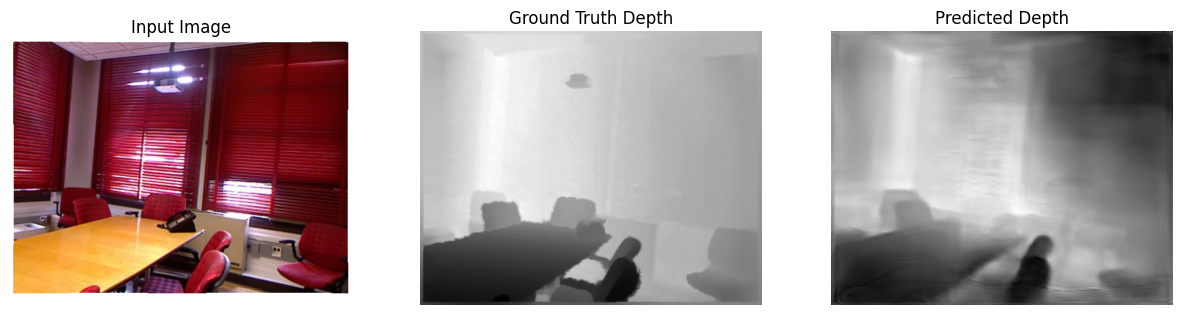

In [18]:
import torch
import segmentation_models_pytorch as smp
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# ตั้งค่า Model
ENCODER = 'resnet50'
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None,
)
model.to(DEVICE)
model.load_state_dict(torch.load('./epoch_8_model.pth', map_location=DEVICE))
model.eval()

# Transformation
image_transform = transforms.Compose([
    transforms.Resize((256, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

depth_transform = transforms.Compose([
    transforms.Resize((256, 320)),
    transforms.ToTensor(),
])

def visualize_results(image, depth_gt, depth_pred):
    """แสดงผลลัพธ์ภาพต้นฉบับ, Depth Map จริง, และ Prediction"""
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(depth_gt, cmap='gray')
    plt.title('Ground Truth Depth')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(depth_pred, cmap='gray')
    plt.title('Predicted Depth')
    plt.axis('off')

    plt.show()

def load_image_and_depth(image_path, depth_path):
    """โหลดภาพและ depth map จากไฟล์"""
    image = Image.open(image_path).convert('RGB')
    depth_gt = Image.open(depth_path)

    image_tensor = image_transform(image).unsqueeze(0).to(DEVICE)
    depth_gt_np = depth_transform(depth_gt).squeeze(0).numpy()

    return image, depth_gt_np, image_tensor

# เตรียมภาพและ Ground Truth Depth Map
img_path = './data/nyu2_test/00038_colors.png'
depth_path = './data/nyu2_test/00038_depth.png'

image, depth_gt_np, image_tensor = load_image_and_depth(img_path, depth_path)

# Inference
with torch.no_grad():
    depth_pred_tensor = model(image_tensor).squeeze(1).cpu().numpy()[0]

# Rescale ผลลัพธ์การพยากรณ์ให้เป็นช่วง [0, 1]
depth_pred = (depth_pred_tensor - depth_pred_tensor.min()) / (depth_pred_tensor.max() - depth_pred_tensor.min())

# แสดงผลลัพธ์
visualize_results(np.array(image), depth_gt_np, depth_pred)
